In [2]:
import keras.layers as KL
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np

In [3]:
class BatchNorm(KL.BatchNormalization):
    def call(self, inputs, training=None):
        return super(self.__class__, self).call(inputs, training=False)

In [4]:
def building_block(filters, block):
    if block !=0 :
        stride = 1
    else:
        stride = 2
    def f(x):
        y = KL.Conv2D(filters, (1,1), strides=stride)(x)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(filters, (3,3), padding="same")(y)
        y = BatchNorm(axis=3)(y)
        y = KL.Activation("relu")(y)
        
        y = KL.Conv2D(4*filters, (1,1))(y)
        y = BatchNorm(axis=3)(y)
        
        if block == 0:
            shorcut = KL.Conv2D(4*filters, (1,1), strides=stride)(x)
            shorcut = BatchNorm(axis=3)(shorcut)
        else:
            shorcut = x
        y = KL.Add()([y, shorcut])
        y = KL.Activation("relu")(y)
        return y
    return f

In [5]:
def resNet_featureExtractor(inputs):
    x = KL.Conv2D(64, (3,3), padding="same")(inputs)
    x = BatchNorm(axis=3)(x)
    x = KL.Activation("relu")(x)
    
    filters = 64
    blocks = [6, 6, 6]
    for i, block_num in enumerate(blocks):
        for block_id in range(block_num):
            x = building_block(filters, block_id)(x)
        filters *= 2
    return x

In [6]:
def rpn_net(inputs, k):
    shared_map = KL.Conv2D(256, (3,3), padding="same")(inputs)
    shared_map = KL.Activation("linear")(shared_map)
    rpn_class = KL.Conv2D(2*k, (1,1))(shared_map)
    rpn_class = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0],-1,2]))(rpn_class)
    rpn_class = KL.Activation("linear")(rpn_class)
    rpn_prob = KL.Activation("softmax")(rpn_class)
    
    y = KL.Conv2D(4*k, (1,1))(shared_map)
    y = KL.Activation("linear")(y)
    rpn_bbox = KL.Lambda(lambda x: tf.reshape(x, [tf.shape(x)[0],-1,4]))(y)
    return rpn_class, rpn_prob, rpn_bbox

In [7]:
def rpn_class_loss(rpn_match, rpn_class_logits):
    ## rpn_match (None, 576, 1)
    ## rpn_class_logits (None, 576, 2)
    rpn_match = tf.squeeze(rpn_match, -1)
    indices = tf.where(K.not_equal(rpn_match, 0))
    anchor_class = K.cast(K.equal(rpn_match, 1), tf.int32)
    print(type(anchor_class), anchor_class)
    rpn_class_logits = tf.gather_nd(rpn_class_logits, indices)     ### prediction
    anchor_class = tf.gather_nd(anchor_class, indices)   ### target
    loss = K.sparse_categorical_crossentropy(target=anchor_class, output=rpn_class_logits, from_logits=True)
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

def batch_back(x, counts, num_rows):
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def rpn_bbox_loss(target_bbox, rpn_match, rpn_bbox):
    rpn_match = tf.squeeze(rpn_match, -1)
    indices = tf.where(K.equal(rpn_match, 1))
    rpn_bbox = tf.gather_nd(rpn_bbox, indices)
    batch_counts = K.sum(K.cast(K.equal(rpn_match, 1), tf.int32), axis=1)
    target_bbox = batch_back(target_bbox, batch_counts, 20)
    diff = K.abs(target_bbox - rpn_bbox)
    less_than_one = K.cast(K.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    loss = K.switch(tf.size(loss) > 0 , K.mean(loss), tf.constant(0.0))
    return loss

In [8]:
input_image = KL.Input(shape=[64,64,3], dtype=tf.float32)
input_bboxes = KL.Input(shape=[None,4], dtype=tf.float32)
input_class_ids = KL.Input(shape=[None],dtype=tf.int32)
input_rpn_match = KL.Input(shape=[None, 1], dtype=tf.int32)
input_rpn_bbox = KL.Input(shape=[None, 4], dtype=tf.float32)

In [9]:
feature_map = resNet_featureExtractor(input_image)
rpn_class, rpn_prob, rpn_bbox = rpn_net(feature_map, 9)

loss_rpn_match = KL.Lambda(lambda x: rpn_class_loss(*x), name="loss_rpn_match")([input_rpn_match, rpn_class])

loss_rpn_bbox = KL.Lambda(lambda x: rpn_bbox_loss(*x), name="loss_rpn_bbox")([input_rpn_bbox, input_rpn_match, rpn_bbox])

model = Model([input_image, input_bboxes, input_class_ids, input_rpn_match, input_rpn_bbox],
              [rpn_class, rpn_prob, rpn_bbox, loss_rpn_match, loss_rpn_bbox])



Instructions for updating:
Colocations handled automatically by placer.
<class 'tensorflow.python.framework.ops.Tensor'> Tensor("loss_rpn_match/Cast:0", shape=(?, ?), dtype=int32)
<class 'tensorflow.python.framework.ops.Tensor'> Tensor("loss_rpn_match/Cast_2:0", shape=(?, ?), dtype=int32)


In [10]:
import keras
loss_lay1 = model.get_layer("loss_rpn_match").output
loss_lay2 = model.get_layer("loss_rpn_bbox").output

model.add_loss(tf.reduce_mean(loss_lay1))
model.add_loss(tf.reduce_mean(loss_lay2))

model.compile(loss=[None]*len(model.output), optimizer=keras.optimizers.SGD(lr=0.00005, momentum=0.9))

model.metrics_names.append("loss_rpn_match")
model.metrics_tensors.append(tf.reduce_mean(loss_lay1, keep_dims=True))

model.metrics_names.append("loss_rpn_bbox")
model.metrics_tensors.append(tf.reduce_mean(loss_lay2, keep_dims=True))
model.summary

<bound method Network.summary of <keras.engine.training.Model object at 0xb2d5e6a20>>

In [11]:
from utils import shapeData as dataSet
from config import Config

config = Config()
dataset = dataSet([64,64], config=config)

In [12]:
def data_Gen(dataset, num_batch, batch_size, config):
    for _ in range(num_batch):
        images = []
        bboxes = []
        class_ids = []
        rpn_matchs = []
        rpn_bboxes = []
        for i in range(batch_size):
            image, bbox, class_id, rpn_match, rpn_bbox, _ = data = dataset.load_data()
            pad_num = config.max_gt_obj - bbox.shape[0]
            pad_box = np.zeros((pad_num, 4))
            pad_ids = np.zeros((pad_num, 1))
            bbox = np.concatenate([bbox, pad_box], axis=0)
            class_id = np.concatenate([class_id, pad_ids], axis=0)
        
            images.append(image)
            bboxes.append(bbox)
            class_ids.append(class_id)
            rpn_matchs.append(rpn_match)
            rpn_bboxes.append(rpn_bbox)
        images = np.concatenate(images, 0).reshape(batch_size, config.image_size[0],config.image_size[1] , 3)
        bboxes = np.concatenate(bboxes, 0).reshape(batch_size, -1 , 4)
        class_ids = np.concatenate(class_ids, 0).reshape(batch_size, -1 )
        rpn_matchs = np.concatenate(rpn_matchs, 0).reshape(batch_size, -1 , 1)
        rpn_bboxes = np.concatenate(rpn_bboxes, 0).reshape(batch_size, -1 , 4)
        yield [images, bboxes, class_ids, rpn_matchs, rpn_bboxes],[]

In [13]:
dataGen = data_Gen(dataset, 35000, 20, config)

In [14]:
#his = model.fit_generator(dataGen, steps_per_epoch=20, epochs=20)
#you can choose to load to trained model. If you wish to train this model, just to uncomment last commond and ignore next block. 
#For this model you will load, I just trained for 20 epoch. I accidently lost the 500 epoch one.

In [15]:
#model.save_weights("model_material.h5")
model.load_weights("model_material.h5")

In [16]:
def anchor_refinement(boxes, deltas):
    boxes = tf.cast(boxes, tf.float32)
    h = boxes[:, 2] - boxes[:, 0]
    w = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + h / 2
    center_x = boxes[:, 1] + w / 2

    center_y += deltas[:, 0] * h
    center_x += deltas[:, 1] * w
    h *= tf.exp(deltas[:, 2])
    w *= tf.exp(deltas[:, 3])
    
    y1 = center_y - h / 2
    x1 = center_x - w / 2
    y2 = center_y + h / 2
    x2 = center_x + w / 2
    boxes = tf.stack([y1, x1, y2, x2], axis=1)
    return boxes
    
def boxes_clip(boxes, window):
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    cliped = tf.concat([y1, x1, y2, x2], axis=1)
    cliped.set_shape((cliped.shape[0], 4))
    return cliped
    
def batch_slice(inputs, graph_fn, batch_size):
    if not isinstance(inputs, list):
        inputs = [inputs]
    output = []
    for i in range(batch_size):
        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (list, tuple)):
            output_slice = [output_slice]
        output.append(output_slice)
    output = list(zip(*output))
    result = [tf.stack(o, axis=0) for o in output]
    if len(result)==1:
        result = result[0]
    return result

import keras.engine as KE

class proposal(KE.Layer):
    def __init__(self, proposal_count, nms_thresh, anchors, batch_size, config=None, **kwargs):
        super(proposal, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.anchors = anchors
        self.nms_thresh = nms_thresh
        self.batch_size = batch_size
        self.config = config
    
    def call(self, inputs):
        probs = inputs[0][:, :, 1]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, (1, 1, 4))
        prenms_num = min(100, self.anchors.shape[0])
        idxs = tf.nn.top_k(probs, prenms_num).indices
        
        probs = batch_slice([probs, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        deltas = batch_slice([deltas, idxs], lambda x,y:tf.gather(x, y), self.batch_size)
        anchors = batch_slice([idxs], lambda x:tf.gather(self.anchors,x), self.batch_size)
        refined_boxes = batch_slice([anchors, deltas], lambda x,y:anchor_refinement(x,y), self.batch_size)
        H,W = self.config.image_size[:2]
        windows = np.array([0,0,H,W]).astype(np.float32)
        cliped_boxes = batch_slice([refined_boxes], lambda x:boxes_clip(x, windows), self.batch_size)
        normalized_boxes = cliped_boxes / np.array([H,W,H,W])
        def nms(normalized_boxes, scores):
            idxs_ = tf.image.non_max_suppression(normalized_boxes, scores, self.proposal_count, self.nms_thresh)
            box = tf.gather(normalized_boxes, idxs_)
            pad_num = tf.maximum(self.proposal_count - tf.shape(normalized_boxes)[0],0)
            box = tf.pad(box, [(0,pad_num),(0,0)])
            return box
        proposal_ = batch_slice([normalized_boxes, probs], nms, self.batch_size)
        return proposal_
    
    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)


In [17]:
test_data = next(dataGen)[0]

In [18]:
images = test_data[0]
bboxes = test_data[1]
class_ids = test_data[2]
rpn_matchs = test_data[3]
rpn_bboxes = test_data[4]


rpn_class, rpn_prob, rpn_bbox, _, _ = \
                model.predict([images, bboxes, class_ids, rpn_matchs, rpn_bboxes])

In [19]:
rpn_class = tf.convert_to_tensor(rpn_class)
rpn_prob = tf.convert_to_tensor(rpn_prob)
rpn_bbox = tf.convert_to_tensor(rpn_bbox)

In [20]:
import utils

anchors = utils.anchor_gen([8,8], ratios=config.ratios, scales=config.scales, rpn_stride=config.rpn_stride, 
                           anchor_stride = config.anchor_stride)


proposals = proposal(proposal_count=16, nms_thresh=0.7, anchors=anchors, batch_size=20, config=config)([rpn_prob, rpn_bbox])

In [21]:
sess = tf.Session()

proposals_ = sess.run(proposals) * 64
#print(proposals.shape)

In [22]:
import random

ix = random.sample(range(20), 1)[0]
print(ix)
proposal_ = proposals_[ix]
img = images[ix]

19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


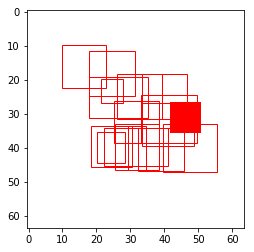

In [31]:
import random

ix = random.sample(range(20), 1)[0]
proposal_ = proposals_[ix]
img = images[ix]
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.imshow(img)
axs = plt.gca()

for i in range(proposal_.shape[0]):
    box = proposal_[i]
    rec = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], facecolor='none', edgecolor='r')
    axs.add_patch(rec)